In [1]:
import os
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from tqdm import tqdm
import transfer_matrix as tm
from scipy.optimize import curve_fit
from IPython.display import HTML, display
import scipy.constants as const

In [2]:
# Constants
GHz = 1.0e9
h = 6.6261e-34  #Planck constant [J/s]
kB = 1.3806e-23 #Boltzmann constant [J/K]
c = 299792458.0 #Speed of light [m/s]
eps0 = 8.85e-12 #Vacuum Permitivity
Tcmb = 2.725    #CMB Temperatrure [K]

In [3]:
freqs = np.linspace(60*GHz, 220*GHz, 200)

In [4]:
# Loads bandpasses

filenames = ["inputs/bandpasses/MF1_w_OMT.txt", "inputs/bandpasses/MF2_w_OMT.txt"]

bps = []
band_centers = [90*GHz, 150*GHz]
shifts = [0, 0.005, 0.01, 0.03, 0.05]

for band_id in [0, 1]:
    fs, ts = np.loadtxt(filenames[band_id], unpack = True)
    bps.append(np.array([np.interp(f, fs *GHz, ts) for f in freqs]))
    
def shift_bp(bp, shift, center):
    """Shifts bandpass by fraction of center frequencty without changing domain."""
    return np.array([np.interp(f, freqs + center * shift, bp) for f in freqs])

In [5]:
# Loads HWP Models
mats = tm.loadMaterials("inputs/hwp_models/materials.txt")
stacks = {}
ARLayers = 3
layers = ["3Layer", "4Layer", "5Layer"]

for layer in layers:
    stack_file = os.path.join('inputs',"hwp_models", layer, f"stack_{ARLayers}LayerAR.txt")
    stacks[layer] = tm.loadStack(mats, stack_file)
    
# Detector Mueller matrix:
M_det = .5 * np.array([[1,1,0,0],[1,1,0,0],[0,0,0,0],[0,0,0,0]])

inc_angle = np.deg2rad(0.0)
chis = np.linspace(1, 1+2*np.pi, 100)
muellers = {} # Mueller matrices indexed by Mueller[layers][freq_index][chi_index]

# Calculates a Mueller matrix for each frequency and rotation angle (might be overkill)
# This takes about 3 min to run
for key, stack in stacks.items():
    ms = []
    for f in tqdm(freqs):
        ms.append([tm.Mueller(stack, f, 0, chi) for chi in chis])
    muellers[key] = np.array(ms)


100%|██████████| 200/200 [01:39<00:00,  2.03it/s]


In [36]:
# for layer in muellers.keys():
#     file = f"inputs/hwp_models/{layer}/muellers_{ARLayers}LayerAR"
#     np.savez(file, freqs=freqs, chis=chis, muellers=muellers[layer])


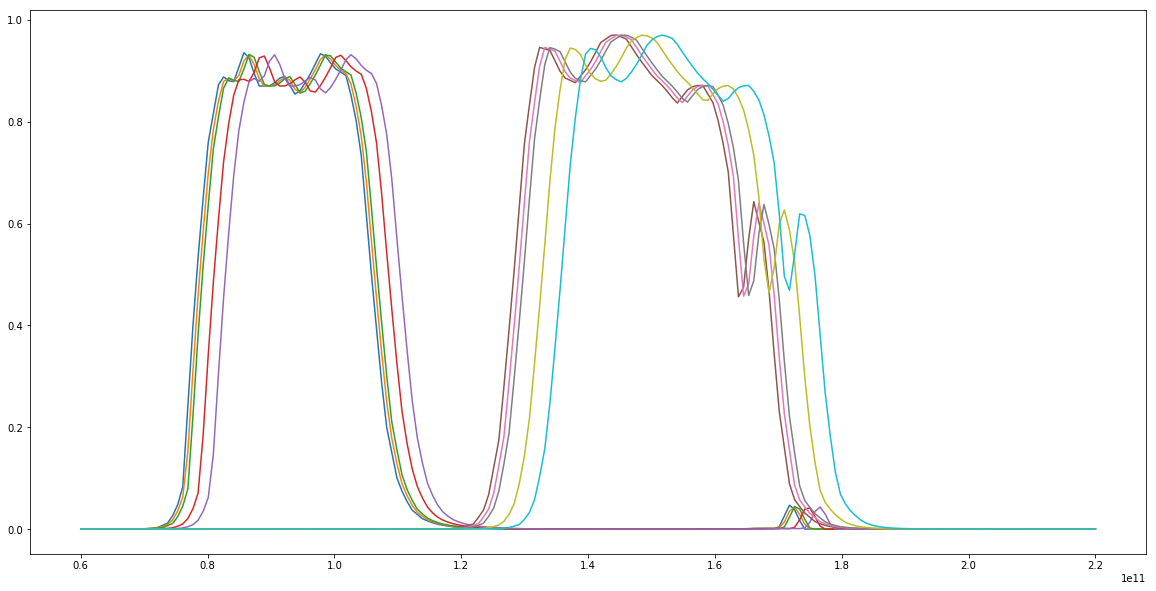

In [6]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

for band_id in [0, 1]:
    for shift in shifts:
        ax.plot(freqs, shift_bp(bps[band_id], shift, band_centers[band_id]))

plt.show()

<font style="font-size: 15px; line-height: 20px">
This creates a mueller matrix for each HWP design, HWP rotation angle, and frequency. This takes like 5 minutes to run, but makes it quicker to calculate the modulation efficiency and polarization angle later on. Mueller matrices are indext by:
</font>
```
muellers[layers][chi_index][freq_index]
```

<font style="font-size: 15px; line-height: 20px">
For each HWP design this code calculates the modulation efficiency and polarization angle as a function of frequency without taking into account bandpasses.
It does this by calculating the demodulated signal as a function of HWP rotation angle, and then fitting the demodulated signal to `demodFit`, a sum of HWP harmonics.
</font>

In [7]:
def demodFit(x, a0, a1, a2, a3, a4, a5, a6, a7, a8, p1, p2, p3, p4, p5, p6, p7, p8):
    """
        Fitting function for the demodulated signal
    """
    d  = a0 
    d += a1 * np.cos(1 * x - p1)
    d += a2 * np.cos(2 * x - p2)
    d += a3 * np.cos(3 * x - p3)
    d += a4 * np.cos(4 * x - p4)
    d += a5 * np.cos(5 * x - p5)
    d += a6 * np.cos(6 * x - p6)
    d += a7 * np.cos(7 * x - p7)
    d += a8 * np.cos(8 * x - p8)
    return d

S_in = np.array([1,1,0,0])
# Fits amplitudes and phases of first 8 harmonics to demodulated signals without factoring in bandpasses
coeffs = {"A0": {}}
for i in range(1, 9):
    coeffs[f"A{i}"] = {}
    coeffs[f"phi{i}"] = {}

for layer in ["3Layer", "4Layer", "5Layer"]:
    for c in coeffs:
        coeffs[c][layer] = []
    
    #Initial guess for fit
    p = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, np.deg2rad(70), 0, 0, 0, 0]
    for i, f in tqdm(enumerate(freqs)):   
        demod = np.array([M_det.dot(m.dot(S_in))[0] for m in muellers[layer][i]])
        popt, pcov = curve_fit(demodFit, chis, demod, p)
        p = popt
        coeffs["A0"][layer].append(p[0])
        for i in range(1, 9):
            if p[i] < 0:
                coeffs[f"A{i}"][layer].append(-p[i])
                coeffs[f"phi{i}"][layer].append(p[i + 8] + np.pi)   
            else:
                coeffs[f"A{i}"][layer].append(p[i])
                coeffs[f"phi{i}"][layer].append(p[i + 8])   
        
    for c in coeffs:
        coeffs[c][layer] = np.array(coeffs[c][layer])

0it [00:00, ?it/s]/Users/jacoblashner/Library/Python/3.7/lib/python/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
200it [00:01, 134.95it/s]
200it [00:00, 242.88it/s]
200it [00:00, 225.25it/s]


In [35]:
coeffs['A0']

{'A0': {'3Layer': array([0.37583176, 0.43161101, 0.49336101, 0.51452786, 0.48079804,
         0.42343948, 0.3831066 , 0.37747581, 0.40731384, 0.46066683,
         0.50435169, 0.50347081, 0.46632676, 0.42976253, 0.4174685 ,
         0.43420333, 0.47048586, 0.50035597, 0.495219  , 0.45775891,
         0.4175635 , 0.39724977, 0.40392252, 0.43447725, 0.47427205,
         0.49737228, 0.4876417 , 0.45748213, 0.43090601, 0.4225855 ,
         0.43548577, 0.46323805, 0.49029429, 0.49916696, 0.4870921 ,
         0.46838313, 0.4584025 , 0.46341217, 0.4798516 , 0.49590032,
         0.49792445, 0.48269609, 0.46067195, 0.44526914, 0.44396742,
         0.4569305 , 0.47756175, 0.49420576, 0.49706067, 0.48665119,
         0.47251047, 0.46428244, 0.46627966, 0.47697708, 0.49035033,
         0.49895055, 0.49890233, 0.49282653, 0.48705233, 0.48644604,
         0.49156758, 0.49873812, 0.50238208, 0.49900746, 0.49002748,
         0.48053238, 0.47555165, 0.47733099, 0.48460666, 0.49331165,
         0.4986695

/Users/jacoblashner/Library/Python/3.7/lib/python/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


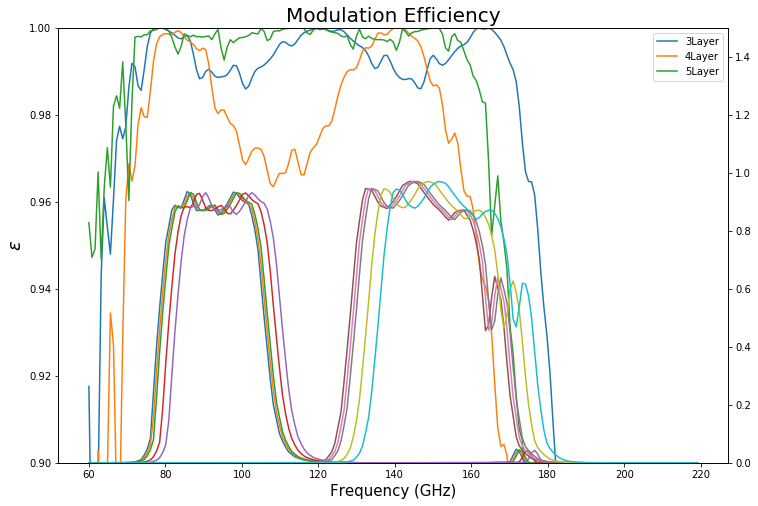

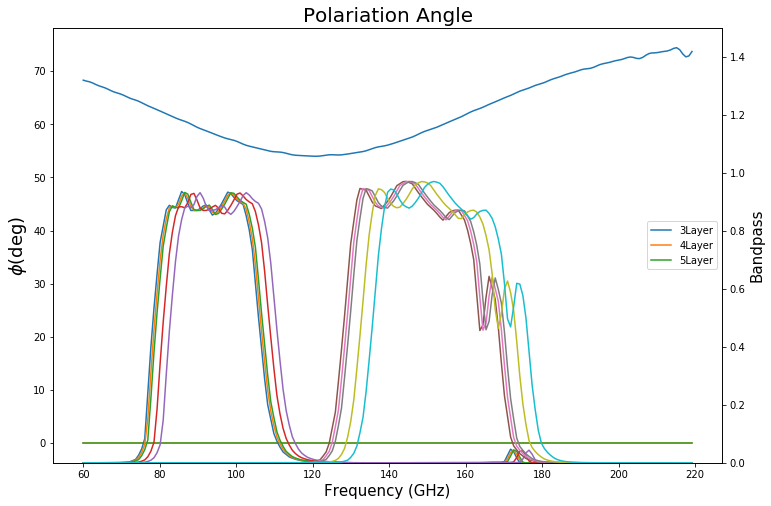

In [8]:
mask = np.array([50 * GHz < f < 220 * GHz for f in freqs])

fig0, ax0 = plt.subplots(1, 1, figsize=(12,8))
fig1, ax1 = plt.subplots(1, 1, figsize=(12,8))

for layer in layers:
    ax0.plot(freqs[mask]/GHz, np.abs(coeffs["A4"][layer][mask]/ coeffs["A0"][layer][mask]), label=layer)
    ax1.plot(freqs[mask]/GHz, np.rad2deg(coeffs["phi4"][layer][mask]/4), label=layer)

twins = [a.twinx() for a in [ax0,ax1]]

for band_id in [0, 1]:
    for shift in shifts:
        twins[0].plot(freqs[mask]/GHz, shift_bp(bps[band_id], shift, band_centers[band_id])[mask])
        twins[1].plot(freqs[mask]/GHz, shift_bp(bps[band_id], shift, band_centers[band_id])[mask])
    

twins[1].set_ylabel("Bandpass", fontsize=15)
twins[1].set_ylim(0, 1.5)
twins[0].set_ylim(0, 1.5)
ax0.legend()
ax0.set_ylim(.9, 1)
ax0.set_xlabel("Frequency (GHz)", fontsize=15)
ax0.set_title("Modulation Efficiency", fontsize=20)
ax0.set_ylabel(r"$\epsilon$", fontsize=18)


ax1.legend()
ax1.set_xlabel("Frequency (GHz)", fontsize=15)
ax1.set_title("Polariation Angle", fontsize=20)
ax1.set_ylabel(r"$\phi$(deg)", fontsize=18)
fig0.savefig("figs/Mod_eff.pdf")
fig1.savefig("figs/Pol_angle.pdf")
fig.show()

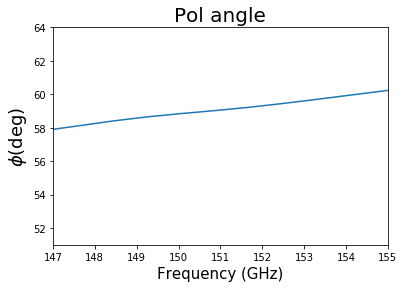

In [14]:

l =layers[0]
mask = np.array([50 * GHz < f < 220 * GHz for f in freqs])
plt.plot(freqs[mask]/GHz, np.rad2deg(coeffs["phi4"][l][mask]/4), label=l)

plt.xlabel("Frequency (GHz)", fontsize=15)
plt.title("Pol angle", fontsize=20)
plt.ylabel(r"$\phi$(deg)", fontsize=18)

plt.xlim(147, 155)
plt.ylim(51,64)
plt.show()

In [59]:
np.deg2rad(70)

1.2217304763960306

In [64]:
def BandAveragedModEff(ms, bandpass, spectrum):
    # ms must be mueller[chi_index][freq_index]
    
    
    demod = []
    S_in = np.array([np.array([1,1,0,0]) * s for s in spectrum])
    for i, chi in enumerate(chis):
        m = ms[i] #muellers[freq_index]
        d = np.array([bandpass[j] * M_det.dot(m[j].dot(S_in[j]))[0] for j in range(len(freqs))])
        averaged = np.trapz(d,x=freqs)/np.trapz(bandpass, x=freqs)
        demod.append(averaged)
#     plt.plot(chis, demod)
#     plt.show()
    p = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0] #Maybe find a better guess than this
    popt, pcov = curve_fit(demodFit, chis, demod, p)
    A0 = popt[0]
    for i in range(1, 9):
        if popt[4] < 0:
            A4 = -popt[4]
            phi4 = popt[4 + 8] #np.pi # np.pi
        else:
            A4 = popt[4]
            phi4 = popt[4 + 8]
            
    return (A4/A0, phi4)
        

In [17]:
import copy
import collections
def makehash():
    return collections.defaultdict(makehash)


In [18]:
bcs = makehash()
bcs[0]['a = -3']['3Layer'][1] = 90

In [42]:
bcs

defaultdict(<function __main__.makehash()>,
            {0: defaultdict(<function __main__.makehash()>,
                         {'a = -3': defaultdict(<function __main__.makehash()>,
                                      {'3Layer': defaultdict(<function __main__.makehash()>,
                                                   {1: 90})})})})

In [19]:
def power_law(freq, index):
    return freq**index

def Blackbody(freq, T, beta = 0):
    return freq**(3 + beta) / (np.exp(const.h * freq / (const.k * T)) - 1)

In [ ]:
np.trapz

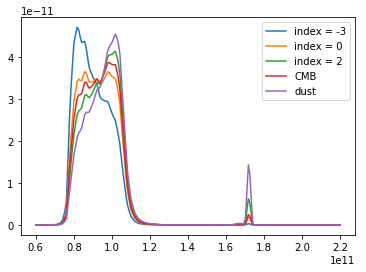

In [27]:
bid = 0
for spec_name, spec in spectra.items():
    norm = np.trapz(bps[bid]*spec, freqs)
    bc = np.trapz(bps[bid]*spec*freqs, freqs)/norm
    plt.plot(freqs, bps[bid] * spec / norm , label = spec_name)
plt.legend()
plt.show()

In [65]:
spectra = collections.OrderedDict({
    'index = -3': power_law(freqs, -3),
    'index = 0': power_law(freqs, 0),
    'index = 2': power_law(freqs, 2),
    'CMB': Blackbody(freqs, 2.725),
    'dust': Blackbody(freqs, 19.6, beta=1.59)
})

# Calculates band-averaged modulation efficiency and polarization angle
mod_effs = {} # Indexed by mod_effs[(layer, band_id, spec_name, shift)]
pol_angles = {}
bcs = {}      # Indexed by (band_id, spec_name, shift)

for bid in [0, 1]:
    for spec_name, spectrum in spectra.items():
        center = np.trapz(spectrum * bps[bid] * freqs)/np.trapz(spectrum * bps[bid])     
         
        for shift in shifts:
            bp = shift_bp(bps[bid], shift, center)
            bcs[(bid, spec_name, shift)] = center * (1 + shift)
            
            norm = np.trapz(bp * spectrum, x=freqs)
            
            for layer in layers:
                ms = np.swapaxes(muellers[layer], 0, 1) #Mueller[chi, freq_index]
                meff, pol = BandAveragedModEff(ms, bp, spectrum/norm)
                mod_effs[(layer, bid, spec_name, shift)] = meff
                pol_angles[(layer, bid, spec_name, shift)] = pol

In [48]:
print(bcs[(1, "index = -3", 0)])

144551439513.9034


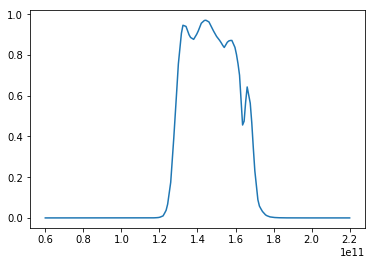

In [22]:
plt.plot(freqs, bps[1])

In [23]:
spectrum = spectra['index = -3']
ms = np.swapaxes(muellers["3Layer"], 0, 1)
BandAveragedModEff(ms, bps[1], spectrum)

(0.9723700711647006, 0.8856033509440958)

In [46]:
print(np.rad2deg(np.array([pol_angles[(layer, bid, 'index = -3', s)] for s in shifts])))

[50.7414434  51.42307595 52.11885392 55.04051614 58.12851891]


No handles with labels found to put in legend.


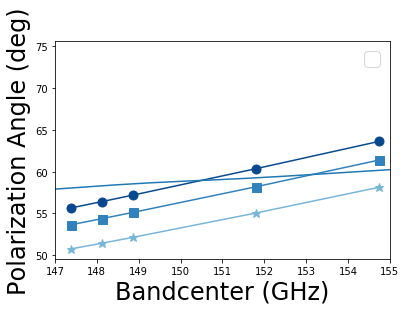

In [67]:
# fig, ax = plt.subplots(1,1, figsize=(20,10))

layer_cms = [plt.get_cmap(name) for name in ["Blues", "Greens", "Oranges"]]

#Index markers
marker =  ['*', 's', 'o', 'd', 'v', 'x', 'star', 'square', 'plus']
lines = {}
bid = 1


for j, layer in enumerate(layers[0:1]):
    for i, spec_name in enumerate(['index = -3', 'index = 0', 'index = 2']):
        xs = np.array([bcs[(bid, "index = 0", s)] for s in shifts]) / GHz
#         xs = np.array([bcs[(bid, spec_name, s)] for s in shifts]) / GHz
        ys = np.array([pol_angles[(layer, bid, spec_name, s)] for s in shifts])
        ys = np.rad2deg(ys)
    
        kwargs = {
            'color': layer_cms[j](int(i/5 * (400-120) + 120)),
            'markersize': 9
        }
        if i==len(spectra.keys()) - 1:
            kwargs["label"] = layer
        lines[(layer, spec_name)] = plt.plot(xs, ys, "-{}".format(marker[i]), **kwargs)
            
        
cmap = plt.get_cmap("Greys")
color_vals = [100,130, 160,180, 200, 240]
handles = []
labels = []
for i, spec_name in enumerate(spectra.keys()):
    handles.append(Line2D([0], [0], marker=marker[i], color=cmap(color_vals[i]), markersize=10))
    labels.append(spec_name)

# l1 = plt.legend(handles, labels,prop={'size': 20}, bbox_to_anchor=(0,0, 1, .8), loc="upper right")
plt.legend(prop={'size': 20})
# plt.gca().add_artist(l1)
# plt.legend()
plt.xlabel("Bandcenter (GHz)",fontsize=24)
plt.ylabel("Polarization Angle (deg)", fontsize=24)

l =layers[0]
mask = np.array([50 * GHz < f < 220 * GHz for f in freqs])
plt.plot(freqs[mask]/GHz, np.rad2deg(coeffs["phi4"][l][mask]/4), label=l)
plt.xlim(147,155)

# plt.savefig('figs/polangles_150_3layer.pdf')
# plt.savefig("figs/spec_indices_150_polangle_45Layer.pdf")
plt.show()

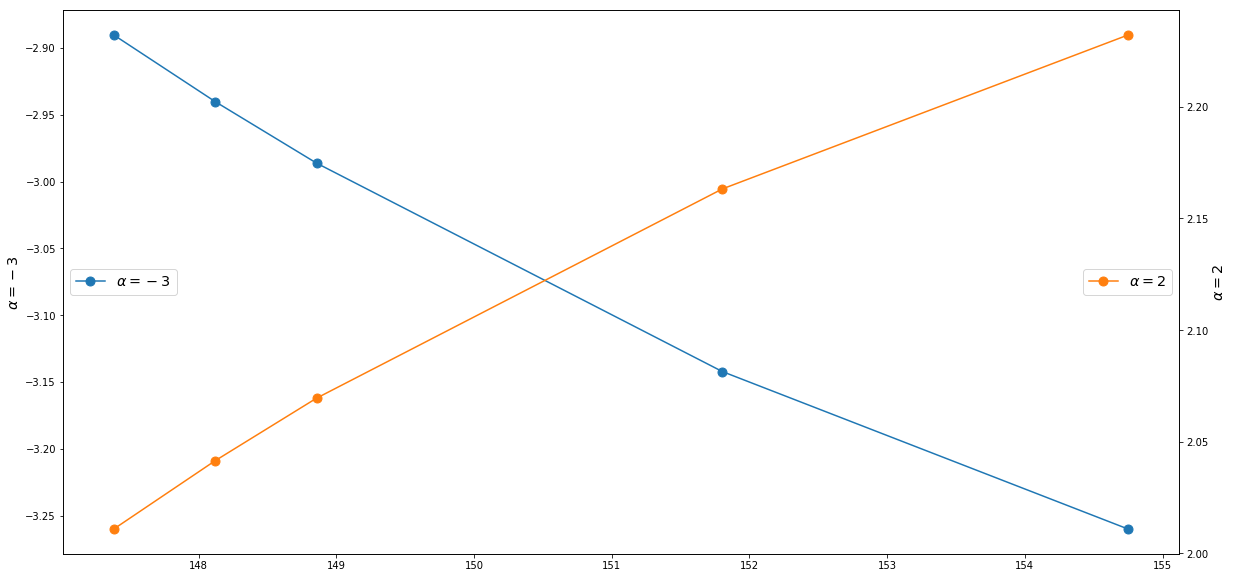

In [25]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

layer_cms = [plt.get_cmap(name) for name in ["Blues", "Greens", "Oranges"]]

#Index markers
marker =  ['*', 's', 'o', 'd', 'v', 'x', 'star', 'square', 'plus']
lines = {}
bid = 1

layer = "3Layer"
xs = np.array([bcs[(bid, "index = 0", s)] for s in shifts]) / GHz
ys = np.array([pol_angles[(layer, bid, "index = -3", s)] for s in shifts])
ys -= np.array([pol_angles[(layer, bid, "index = 0", s)] for s in shifts])
ys = np.rad2deg(ys)

kwargs = {
    'color': "C0",
    'markersize': 9
}
ax.plot(xs, ys, "-o", **kwargs, label=r"$\alpha = -3$")
ax.legend(loc="center left", fontsize="x-large")
ax.set_ylabel (r"$\alpha=-3$", fontsize="x-large")
twin = ax.twinx()
xs = np.array([bcs[(bid, "index = 0", s)] for s in shifts]) / GHz
ys = np.array([pol_angles[(layer, bid, "index = 2", s)] for s in shifts])
ys -= np.array([pol_angles[(layer, bid, "index = 0", s)] for s in shifts])
ys = np.rad2deg(ys)
kwargs = {
    'color': "C1",
    'markersize': 9
}
twin.plot(xs, ys, "-o", **kwargs, label=r"$\alpha = 2$")
twin.legend(loc="center right", fontsize="x-large")
twin.set_ylabel (r"$\alpha=2$", fontsize="x-large")
fig.show()
fig.savefig("figs/index_comparison_b1.pdf")

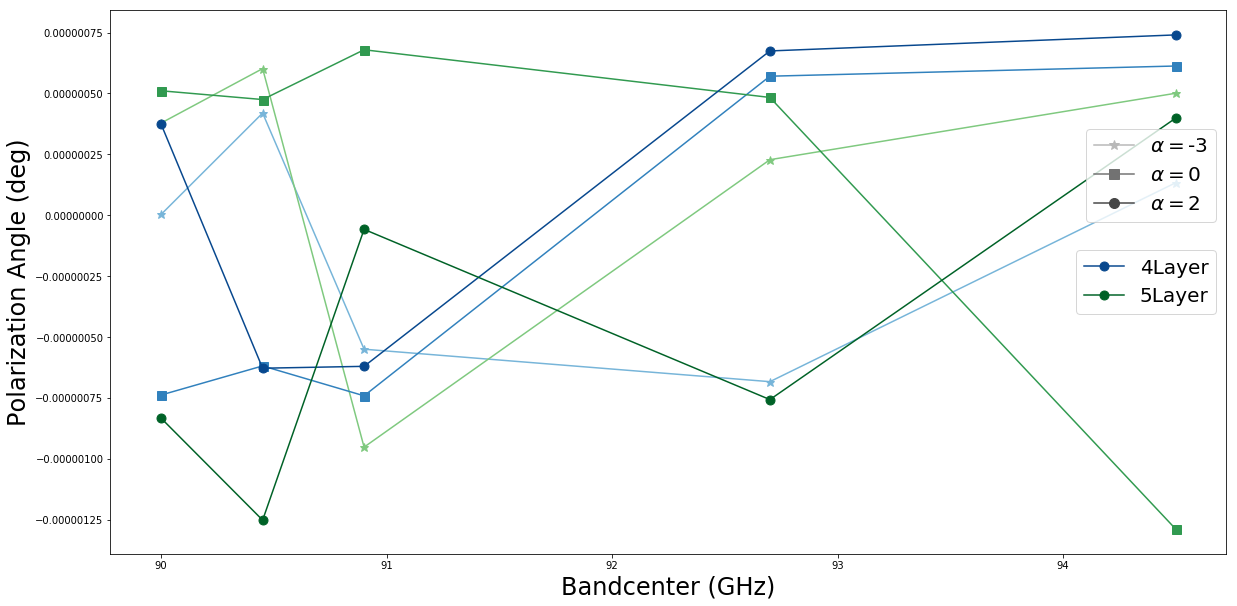

In [330]:
fig, ax = plt.subplots(1,1, figsize=(20,10))


bp_shifts = [0, .5, 1, 3, 5]
shift_names = ["", "+0.5%", "+1%", "+3%","+5%"]

layer_cms = [plt.get_cmap(name) for name in ["Blues", "Greens", "Oranges"]]

#Index markers
marker =  ['*', 's', 'o', 'd', 'v', 'x']
layers = ["3Layer", "4Layer", "5Layer"]
layers = ["4Layer", "5Layer"]

lines = {}
for i,alpha in enumerate(indices):
    for j, layer in enumerate(layers):
        xs = [90*(1+x/100) for x in bp_shifts]
        ys = [np.rad2deg(mod_effs[alpha][layer]["90{}".format(x)][1]) for x in shift_names]
        
    
        kwargs = {
            'color': layer_cms[j](int(i/5 * (400-120) + 120)),
            'markersize': 9
        }
        if i==len(indices) - 1:
            kwargs["label"] = layer
        lines[(alpha, layer)] = plt.plot(xs, ys, "-{}".format(marker[i]), **kwargs)
        
        

        
        
cmap = plt.get_cmap("Greys")
color_vals = [100,160, 200]
handles = []
labels = []
for i in range(3):
    handles.append(Line2D([0], [0], marker=marker[i], color=cmap(color_vals[i]), markersize=10))
    labels.append(r"$\alpha=${}".format(indices[i]))

l1 = plt.legend(handles, labels,prop={'size': 20}, bbox_to_anchor=(0,0, 1, .8), loc="upper right")
plt.legend(prop={'size': 20})
plt.gca().add_artist(l1)
# plt.legend()
plt.xlabel("Bandcenter (GHz)",fontsize=24)
plt.ylabel("Polarization Angle (deg)", fontsize=24)
# plt.savefig("figs/spec_indices_90_polangle_45Layer.pdf")
plt.show()

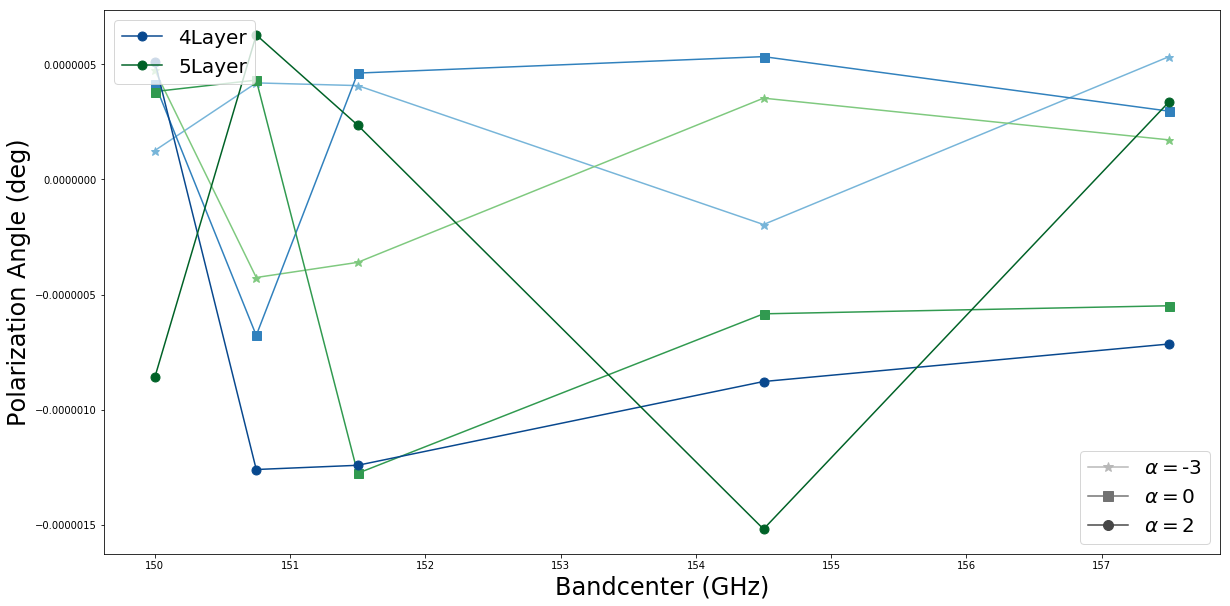

In [328]:
fig, ax = plt.subplots(1,1, figsize=(20,10))


bp_shifts = [0, .5, 1, 3, 5]
shift_names = ["", "+0.5%", "+1%", "+3%","+5%"]

layer_cms = [plt.get_cmap(name) for name in ["Blues", "Greens", "Oranges"]]

#Index markers
layers = ["3Layer", "4Layer", "5Layer"]
layers = ["4Layer", "5Layer"]

lines = {}
for i,alpha in enumerate(indices):
    for j, layer in enumerate(layers):
        xs = [150*(1+x/100) for x in bp_shifts]
        ys = [np.rad2deg(mod_effs[alpha][layer]["150{}".format(x)][1]) for x in shift_names]
        kwargs = {
            'color': layer_cms[j](int(i/5 * (400-120) + 120)),
            'markersize': 9
        }
        if i==len(indices) - 1:
            kwargs["label"] = layer
        plt.plot(xs, ys, "-{}".format(marker[i]), **kwargs)

cmap = plt.get_cmap("Greys")
color_vals = [100,160, 200]
handles = []
labels = []
for i in range(3):
    handles.append(Line2D([0], [0], marker=marker[i], color=cmap(color_vals[i]), markersize=10))
    labels.append(r"$\alpha=${}".format(indices[i]))

l1 = plt.legend(handles, labels,prop={'size': 20}, bbox_to_anchor=(0,0, 1, 1), loc="lower right")

plt.legend(loc="upper left", prop={'size': 20})
plt.xlabel("Bandcenter (GHz)",fontsize=24)
plt.ylabel("Polarization Angle (deg)", fontsize=24)
plt.gca().add_artist(l1)
plt.savefig("figs/spec_indices_150_polangle_45Layer.pdf")

plt.show()

In [174]:
def display_table(data):
    display(HTML(
        '<table><tr>{}</tr></table>'.format(
            '</tr><tr>'.join(
                '<td>{}</td>'.format('</td><td>'.join("{:.1e}".format(x) for x in row)) for row in data)
            )
     ))
    
layer = "5Layer"
bid = 0
table = [[np.rad2deg(pol_angles[(layer, bid, sn, shift)]) for sn in spectra.keys()] for shift in shifts]
display_table(table)

3.8e-07,5.1e-07,-8.3e-07,-1.4e-06,-9.2e-07
1.3e-07,-1.5e-06,4.5e-07,4.5e-07,5.9e-07
-8.2e-07,-6.6e-07,-7.5e-07,6.2e-07,-1.6e-06
-1.2e-06,-1.3e-07,-5.6e-07,5.1e-07,5.8e-07
6.6e-07,2.3e-08,2.2e-07,4.3e-07,1.1e-06
